In [1]:
!pip install --upgrade --quiet phiflow==3.4
from phi.torch.flow import *  
import pylab # for visualizations later on

In [2]:
# closed domain
INFLOW_LOCATION = tensor([(12, 4), (13, 6), (14, 5), (16, 5)], batch('inflow_loc'), channel(vector="x,y"))
INFLOW = (1./3.) * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))
BND = extrapolation.ZERO # closed, boundary conditions for velocity grid below

# uncomment this for a slightly different open domain case
#INFLOW_LOCATION = tensor([(11, 6), (12, 4), (14, 5), (16, 5)], batch('inflow_loc'), channel(vector="x,y"))
#INFLOW = (1./4.) * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))
#BND = extrapolation.BOUNDARY # open boundaries 

INFLOW.shape

(inflow_locᵇ=4, xˢ=32, yˢ=40)

/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:873: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


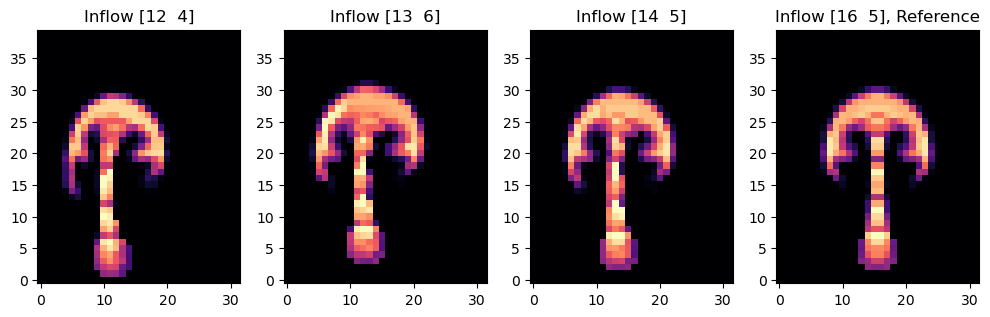

In [3]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))  # sampled at cell centers
velocity = StaggeredGrid(0, BND, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))  # sampled in staggered form at face centers 

def step(smoke, velocity):
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
  buoyancy_force = (smoke * (0, 1)).at(velocity)
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _ = fluid.make_incompressible(velocity, [], Solve('CG', 1e-3, rank_deficiency=0, suppress=[phi.math.NotConverged]) )
  return smoke, velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

# store and show final states (before optimization)
smoke_final = smoke 
fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
  axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}" + (", Reference" if i==3 else ""))
pylab.tight_layout()

In [4]:
initial_smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))
initial_velocity = StaggeredGrid(math.zeros(batch(inflow_loc=4)), BND, x=32, y=40, bounds=Box(x=(0,32), y=(0,40)))
print("Velocity dimensions: "+format(initial_velocity.shape))

def simulate(smoke: CenteredGrid, velocity: StaggeredGrid):
    for _ in range(20):
        smoke,velocity = step(smoke,velocity)
        
    loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]) )
    # optionally, use smoother loss with diffusion steps - no difference here, but can be useful for more complex cases
    #loss = field.l2_loss(diffuse.explicit(smoke - field.stop_gradient(smoke.inflow_loc[-1]), 1, 1, 10))
    
    return loss, smoke, velocity

Velocity dimensions: (xˢ=32, yˢ=40, inflow_locᵇ=4, vectorᶜ=x,y)


In [5]:
sim_grad = field.gradient(simulate, wrt=[1], get_output=False)
(velocity_grad,) = sim_grad(initial_smoke, initial_velocity)

print("Some gradient info: " + format(velocity_grad))
print(format(velocity_grad.values.inflow_loc[0].vector[0])) # one example, location 0, x component, automatically prints size & content range

/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3579: SyntaxWarning: Specifying wrt by position is deprecated in phiml.math.functional_gradient() and phiml.math.jacobian(). Please pass a list or comma-separated string of parameter names.
  exec(code_obj, self.user_global_ns, self.user_ns)


Some gradient info: Field[(xˢ=32, yˢ=40, inflow_locᵇ=4, vectorᶜ=x,y)]
(~vectorᵈ=x,y, xˢ=~(x=31, y=32) int64, yˢ=~(x=40, y=39) int64) 4.86e-08 ± 1.8e+00 (-4e+01...3e+01)


/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


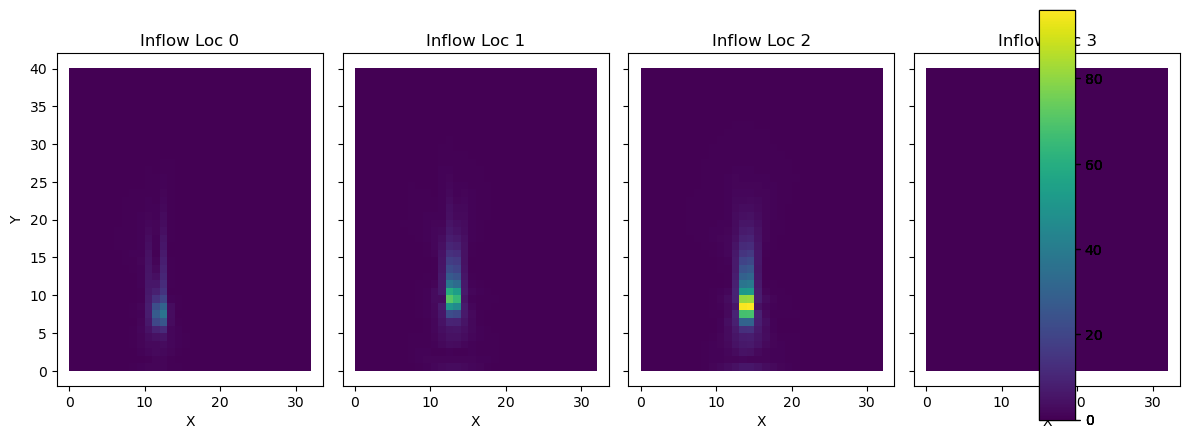

In [6]:
# neat phiflow helper function:
v = vis.plot(field.vec_length(velocity_grad)) # show magnitude

In [7]:
sim_grad_wloss = field.gradient(simulate, wrt=[1], get_output=True) # if we need outputs...

LR = 1e-03 
for optim_step in range(80):    
    (loss, _smoke, _velocity), (velocity_grad,) = sim_grad_wloss(initial_smoke, initial_velocity)
    initial_velocity = initial_velocity - LR * velocity_grad
    if optim_step<3 or optim_step%10==9: print('Optimization step %d, loss: %f' % (optim_step, np.sum(loss.numpy()) ))

Optimization step 0, loss: 298.516632
Optimization step 1, loss: 291.369110
Optimization step 2, loss: 273.887878
Optimization step 9, loss: 238.214050
Optimization step 19, loss: 201.360565
Optimization step 29, loss: 182.805573
Optimization step 39, loss: 177.480499
Optimization step 49, loss: 190.051971
Optimization step 59, loss: 165.783813
Optimization step 69, loss: 167.320984
Optimization step 79, loss: 160.189590


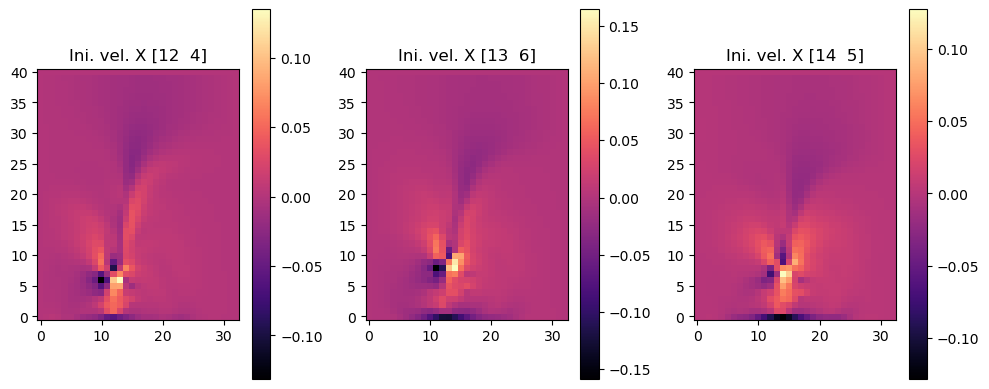

In [8]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,0], origin='lower', cmap='magma')
  axes[i].set_title(f"Ini. vel. X {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[i])
pylab.tight_layout()

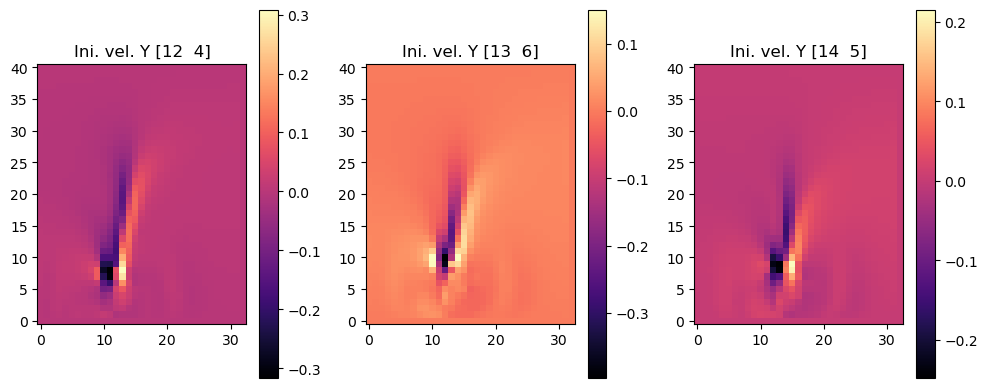

In [9]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,1], origin='lower', cmap='magma')
  axes[i].set_title(f"Ini. vel. Y {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[i])
pylab.tight_layout()

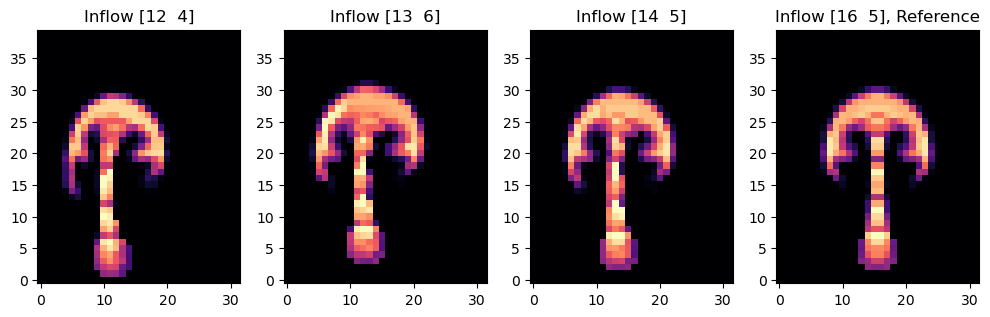

In [10]:
smoke = initial_smoke 
velocity = initial_velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
  axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}" + (", Reference" if i==3 else ""))
pylab.tight_layout()

/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_28708/2631967736.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 6 Axes> than <Figure size 1000x600 with 7 Axes> which fig.colorbar is called on.
  pylab.colorbar(im,ax=axes[0,i])
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_28708/2631967736.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 6 Axes> than <Figure size 1000x600 with 8 Axes> which fig.colorbar is called on.
  pylab.colorbar(im,ax=axes[0,i])
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_28708/2631967736.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 6 Axes> than <Figure size 1000x600 with 9 Axes> which fig.colorbar is called on.
  pylab.colorbar(im,ax=axes[0,i])
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_28708/2631967736.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 6 Axes> than <F

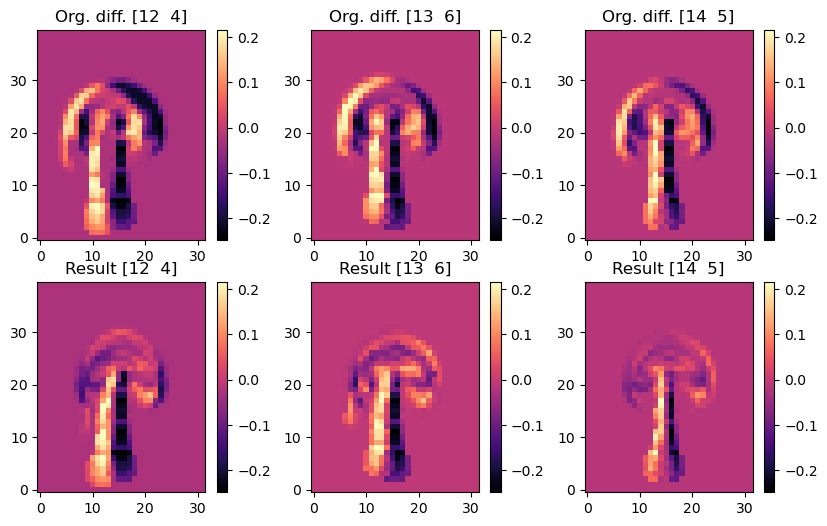

In [11]:
fig, axes = pylab.subplots(2, 3, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  axes[0,i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
  axes[0,i].set_title(f"Org. diff. {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[0,i])
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  axes[1,i].imshow(smoke.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
  axes[1,i].set_title(f"Result {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[1,i])